In [3]:
%matplotlib inline
import sys, time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')

# Helmholtz equation

The Helmholtz equation is the eigenvalue problem for the Laplace operator. Recall the definition of the Laplace operator in 2D:

$$
\begin{align}
\nabla^2 u &= \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}
\end{align}
$$

And recall the definition of eigenvalues $\lambda$ and eigenvectors $\vec{v}$ for a linear transformation $A$:

$$
\begin{align}
A \vec{v} &= \lambda \vec{v}
\end{align}
$$

The Helmholtz equation defines an implicit function $u(x,y)$ that is an *eigenfunction* of the Laplace operator for the eigenvalue $-k^2$. Intuitively, $u$ is a function such that repeatedly applying the Laplace operator only scales the function by $-k^2$.

$$
\begin{align}
\nabla^2 u &= -k^2 u \\
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} &= -k^2 u
\end{align}
$$

Note that, similar to the Laplace and Poisson equations, the Helmholtz equation is time-independent. It describes equilibrium states of a system.

The intuition behind the Laplace operator is it it computes the average difference in values of a function at local spheres around each point from the value at the point. So in the Laplace equation, we are finding functions where the average difference between neighboring values is 0, i.e. the function has a smoothness quality. In the Helmholtz equation, we are finding functions where the average difference between neighboring values is some constant, i.e. there is a constant amount of "turbulence" in the values (is that the proper use of that term?).

The Helmholtz equation as presented in Manduca et al. 2001 and be formed by setting $k^2 = \frac{\rho \omega^2}{G}$, where $G$ is the shear modulus (elasticity to shear waves), $\rho$ is the density, and $\omega$ is the angular frequency. Then simply rearrange:

$$
\begin{align}
\nabla^2 u &= -k^2 u \\
\nabla^2 u &= -\frac{\rho \omega^2}{G} u \\
G \nabla^2 u &= -\rho \omega^2 u
\end{align}
$$


# 1D Helmholtz equation

We will simplify analysis by first considering the one-dimensional case:

$$
    u(x): \mathbb{R} \to \mathbb{R}
$$

The 1D Helmholtz equation is:
$$
\begin{align}  
    G \frac{\partial^2 u}{\partial x^2} &= -\rho \omega^2 u \\
    G u_{xx} &= -\rho \omega^2 u
\end{align}
$$

This is a linear homogeneous second-order ODE:

$$
    G u_{xx} + \rho \omega^2 u = 0
$$

Consider a particular solution:

$$
\begin{align}
    u_1 &= \sin \left(\sqrt{\frac{\rho \omega^2}{G}} x \right) \\
    u_x &= \sqrt{\frac{\rho \omega^2}{G}} \cos \left( \sqrt{\frac{\rho \omega^2}{G}} x \right) \\
    u_{xx} &= -\frac{\rho \omega^2}{G} \sin \left( \sqrt{\frac{\rho \omega^2}{G}} x \right) \\
    G u_{xx} &= -\rho \omega^2 u
\end{align}
$$

And an alternative particular solution:

$$
\begin{align}
    u_1 &= \cos \left(\sqrt{\frac{\rho \omega^2}{G}} x \right) \\
    u_x &= -\sqrt{\frac{\rho \omega^2}{G}} \sin \left( \sqrt{\frac{\rho \omega^2}{G}} x \right) \\
    u_{xx} &= -\frac{\rho \omega^2}{G} \cos \left( \sqrt{\frac{\rho \omega^2}{G}} x \right) \\
    G u_{xx} &= -\rho \omega^2 u
\end{align}
$$

Any linear combination of particular solutions is also a solution:

$$
    u = c_1 u_1 + c_2 u_2
$$

The set $\{u_1, u_2\}$ is a *fundamental set of solutions* if every solution can be written as a linear combination of them. Then their linear combination is the general solution to the ODE. The particular solutions must be linearly independent to form a fundamental set. In our case, this implies that any solution to the 1D Helmholtz equation is a linear combination:

$$
    u = c_1 \sin \left(\sqrt{\frac{\rho \omega^2}{G}} x \right) + c_2 \cos \left(\sqrt{\frac{\rho \omega^2}{G}} x \right)
$$

Note that $u = 0$ is a trivial solution, but it is not linearly independent, so it is not part of the fundamental solution set.

0.06

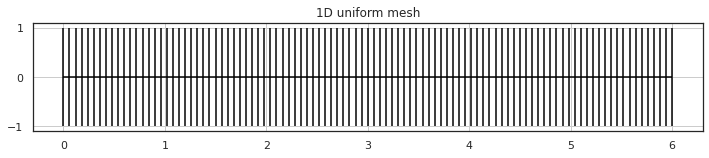

In [243]:
# define the mesh

n_x = 101
x_min, x_max = [0, 6]
dx = (x_max - x_min) / (n_x - 1)

x = np.linspace(x_min, x_max, n_x)

fig, ax = plt.subplots(figsize=(12,2))
ax.hlines(0, x_min, x_max, color='k')
ax.vlines(x, -1, 1, color='k')
ax.grid(True)
ax.set_title('1D uniform mesh')
dx

(-0.9999581210165029, 0.999623110194424, 0.0)

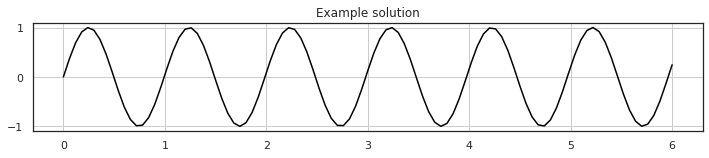

In [244]:
# example solution

G = 0.1
rho = 1
omega = 2
k = np.sqrt(rho/G)*omega
u = np.sin(k*x)

fig, ax = plt.subplots(figsize=(12,2))
ax.plot(x, u, c='k')
ax.grid(True)
ax.set_title('Example solution')
u.min(), u.max(), np.median(u)

(-38.10212152811061, 38.11489096383693, 0.6976429246940589)

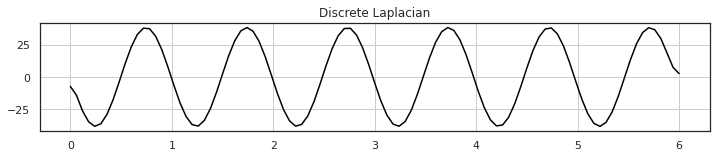

In [245]:
# discrete Laplacian

def laplace_1d(u, dx):
    u_x = np.gradient(u)   
    u_xx = np.gradient(u_x)
    return u_xx / dx**2

Lu = laplace_1d(u, dx)

fig, ax = plt.subplots(figsize=(12,2))
ax.plot(x, Lu, c='k')
ax.grid(True)
ax.set_title('Discrete Laplacian')
Lu.min(), Lu.max(), np.median(Lu)

If we know $u$ and $u_{xx}$, we can easily solve for $G$ by direct inversion.

$$
\begin{align}
    G u_{xx} &= -\rho \omega^2 u \\
    G &= -\rho \omega^2 \frac{u}{u_{xx}}
\end{align}
$$

(-0.37997361640629984, 0.1049414657673481, 0.10494146465776306)

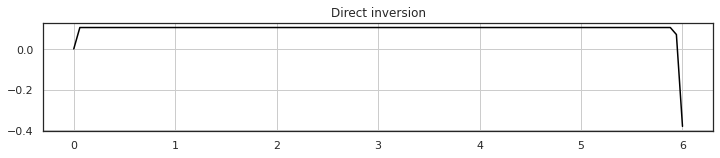

In [246]:
# direct inversion

eps = 1e-8
G = -rho * omega**2 * u / (Lu + eps)

fig, ax = plt.subplots(figsize=(12,2))
ax.plot(x, G, c='k')
ax.grid(True)
ax.set_title('Direct inversion')
G.min(), G.max(), np.median(G)

### 1D Explicit method

We can compute an explicit finite difference approximation:

$$
\begin{align}
    u_{xx} &= -k^2 u \\
    \frac{u_{i+1} - 2 u_i + u_{i-1}}{\Delta x^2} &= -k_i^2 u_i \\
    u_{i+1} - 2 u_i + u_{i-1} &= -\Delta x^2 k_i^2 u_i \\
    u_{i+1} &= 2 u_i - \Delta x^2 k_i^2 u_i - u_{i-1} \\
    u_{i+1} &= (2 - \Delta x^2 k_i^2) u_i - u_{i-1} \\
\end{align}
$$

Which can be used to solve an IVP where we are given $u_0$ and $u_1$.

In [392]:
def evaluate_1d(solver_name, solver, G, u0, x, n_x, dx, rho=1, omega=1, eps=1e-8):
    
    fig, axes = plt.subplots(5, 1, figsize=(12,8))
    color = 'black'
    
    # stiffness parameter
    axes[0].set_title('Stiffness parameter')
    k = np.sqrt(rho/G)*omega
    axes[0].plot(x, G, c=color)
    
    # initial condtions
    axes[1].set_title('Initial conditions')
    axes[1].plot(x, u0, c=color)
    
    # solution method
    axes[2].set_title(solver_name)
    u_pred = solver(u0, k, n_x, dx)
    if u_pred.ndim == 2:
        n_t = len(u_pred)
        for n, u_pred in enumerate(u_pred):
            colors = sns.color_palette('Greys', n_t)
            axes[2].plot(x, u_pred, c=colors[n])
    else:
        axes[2].plot(x, u_pred, c=color)
    
    # discrete Laplacian
    axes[3].set_title('Discrete Laplacian')
    Lu_pred = laplace_1d(u_pred, dx)
    axes[3].plot(x, Lu_pred, c=color)
    
    # direct inversion
    axes[4].set_title('Direct inversion')
    G_pred = -rho * omega**2 * u_pred / (Lu_pred + eps)
    axes[4].plot(x, G_pred, c=color)

    for ax in axes:
        ax.set_axisbelow(True)
        ax.grid(True, linestyle=':')

    sns.despine(fig)
    fig.tight_layout()

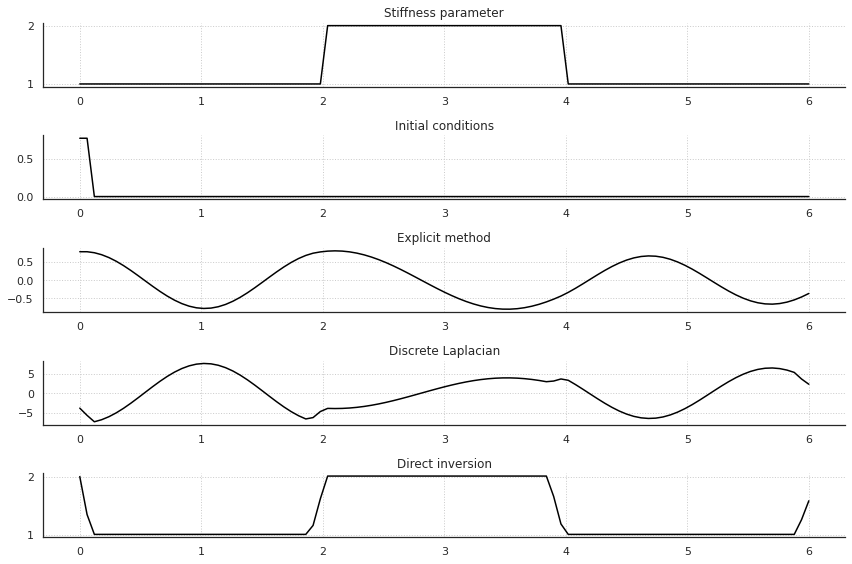

In [393]:
# explicit method using causal/upwind scheme

def explicit_solver_1d(u0, k, n_x, dx):
    u = u0.copy()
    for i in range(2, n_x):
        u[i] = (2 - dx**2 * k[i]**2) * u[i-1] - u[i-2]
    return u

G = np.ones(n_x) * 1.0
G[(x>2) & (x<4)] = 2.0

# initial conditions
u0 = np.zeros(n_x)
u0[:2] = np.random.normal(0, 1)

evaluate_1d('Explicit method', explicit_solver_1d, G, u0, x, n_x, dx, omega=np.pi)

### 1D Implicit method

We can alternatively compute an implicit finite difference approximation:

$$
\begin{align}
    u_{xx} + k^2 u &= 0 \\
    \frac{u_{i+1} - 2 u_i + u_{i-1}}{\Delta x^2} + k_i^2 u_i &= 0 \\
    u_{i+1} - 2 u_i + u_{i-1} + \Delta x^2 k_i^2 u_i &= 0 \\
    u_{i+1} + (\Delta x^2 k_i^2 - 2) u_i + u_{i-1} &= 0 \\
    \mathbf{H} &= \operatorname{tridiag}(1, \Delta x^2 k_i^2 - 2, 1) \\
    \mathbf{H} \mathbf{u} &= 0
\end{align}
$$

In this case, we solve a linear system to obtain $u$ all at once. The boundary conditions must be moved to the RHS.

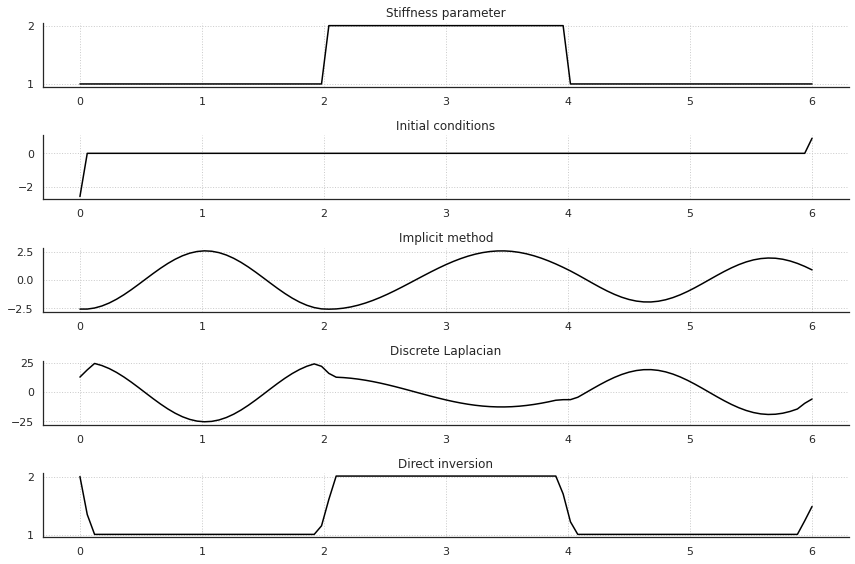

In [395]:
def tridiag(a, b, c, n):
    return (
        a * (np.tri(n, k=-1) - np.tri(n, k=-2)) +
        b * np.eye(n) +
        c * (np.tri(n, k=1) - np.tri(n, k=0))
    )


def implicit_solver_1d(u0, k, n_x, dx):
    
    H = tridiag(1, dx**2 * k[1:-1]**2 - 2, 1, n_x - 2)
    
    rhs = np.zeros(n_x - 2)
    rhs[0]  += -u0[0]
    rhs[-1] += -u0[-1]

    u = u0.copy()
    u[1:-1] = np.linalg.solve(H, rhs)
    return u

# boundary conditions
u0 = np.zeros(n_x)
u0[0] = np.random.normal(0, 1)
u0[-1] = np.random.normal(0, 1)

evaluate_1d('Implicit method', implicit_solver_1d, G, u0, x, n_x, dx, omega=np.pi)

### 1D Iterative method

We can also try an iterative method, despite that the system is time-independent:

$$
\begin{align}
    \mathbf{H} \mathbf{u} &= 0 \\
    \mathbf{H}^\top \mathbf{H} \mathbf{u} &= 0 \\
    \mathbf{H}^\top \mathbf{H} \mathbf{u} &= \frac{\Delta \mathbf{u}}{\Delta t} \\
    \mathbf{H}^\top \mathbf{H} \mathbf{u}^n &= \frac{\mathbf{u}^{n+1} - \mathbf{u}^n}{\Delta t} \\
    \Delta t \mathbf{H}^\top\mathbf{H} \mathbf{u}^n &= \mathbf{u}^{n+1} - \mathbf{u}^n \\
    \mathbf{u}^{n+1} &= \mathbf{u}^n + \Delta t \mathbf{H}^\top\mathbf{H} \mathbf{u}^n
\end{align}
$$

Problem: this assumes that H is SPD, which it is not. It's symmetric, but not definite.

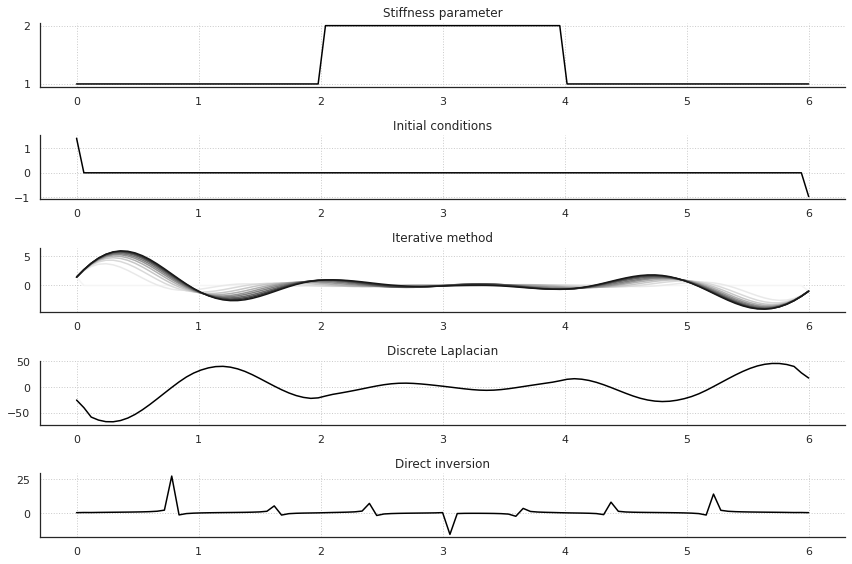

In [446]:
def iterative_solver_1d(u0, k, n_x, dx, max_iter=10000, tol=1e-8, mod=1000):
    
    H = tridiag(1, dx**2 * k**2 - 2, 1, n_x)
    H = H.T @ H
    assert np.all(np.linalg.eig(H)[0] > 0)
    
    dt = 0.01
    
    residual = 0 - H @ u0
    direction = residual

    us = [u0]
    for n in range(max_iter):
        u_prev = us[n]
            
        alpha = direction.dot(residual) / direction.dot(H @ direction)
        
        u = u_prev.copy()
        u[1:-1] = (u_prev + alpha * direction)[1:-1]
        us.append(u)
        
        residual_prev = residual
        residual = 0 - H @ u
        
        # test for convergence
        if np.linalg.norm(residual) < tol or np.linalg.norm(u - u_prev) < tol:
            print(f'Converged in {n+1}')
            break
        
        beta = residual.dot(residual) / residual_prev.dot(residual_prev)
        direction = residual + beta * direction        
    
    return np.stack(us)[::mod]

# boundary conditions
u0 = np.zeros(n_x)
u0[0] = np.random.normal(0, 1)
u0[-1] = np.random.normal(0, 1)

evaluate_1d('Iterative method', iterative_solver_1d, G, u0, x, n_x, dx, omega=np.pi)

### 1D Power method

Given that the Helmholtz equation is an eigenvalue problem for the Laplacian operator, maybe we can use power iteration.

$$
\begin{align}
    u_{xx} &= -k^2 u \\
    \frac{u_{i+1} - 2 u_i + u_{i-1}}{\Delta x^2} &= -k^2 u_i \\
    u_{i+1} - 2 u_i + u_{i-1} &= -k^2 \Delta x^2 u_i \\
    \mathbf{A} \mathbf{u} &= -k^2 \Delta x^2 \mathbf{u} \\
    \mathbf{A} &= \operatorname{tridiag}(1, -2, 1) \\
    \mathbf{u}^{n+1} &= \frac{\mathbf{A} \mathbf{u}^n}{\| \mathbf{A} \mathbf{u}^n \|}
\end{align}
$$

((101, 101), array([ 1., -2.,  1.]))

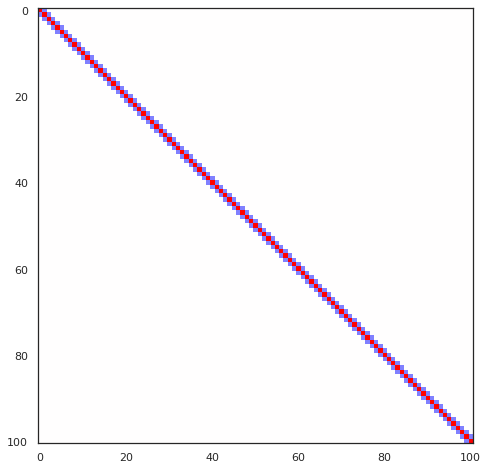

In [124]:
A = tridiag(1, -2, 1, n_x)
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(-A, cmap='bwr', vmin=-2, vmax=2)
A.shape, A[1,:3]

(-0.23128083043439907, 0.2410938966650782, -0.00478907565433102)

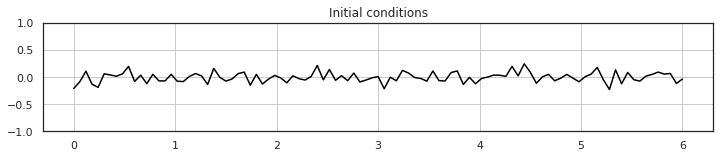

In [134]:
# initial values

u0 = np.random.normal(0, 0.1, n_x)

fig, ax = plt.subplots(figsize=(12,2))
ax.plot(x, u0, c='k')
ax.grid(True)
ax.set_ylim(-1, 1)
ax.set_title('Initial conditions')
u0.min(), u0.max(), np.median(u0)

(-0.13996453337416329, 0.14002800157606668, 0.004309226019070097)

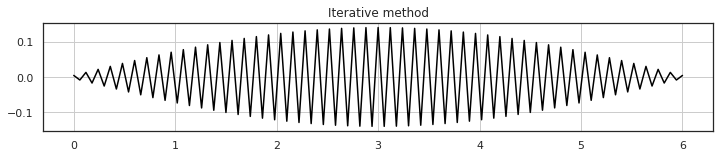

In [135]:
max_iter = 10000
tol = 1e-8
u = u0.copy()

for n in range(max_iter):
    u_prev = u
    u = A @ u
    u_norm = np.linalg.norm(u)
    u /= u_norm

fig, ax = plt.subplots(figsize=(12,2))
ax.plot(x, u, c='k')
ax.grid(True)
ax.set_title('Iterative method')
u.min(), u.max(), np.median(u)

I guess not!

## 2D Helmholtz equation

In [ ]:
# define the mesh
n_x = 201
n_y = 201

x_min, x_max = [-1, 1]
y_min, y_max = [-1, 1]

dx = (x_max - x_min) / (n_x - 1)
dy = (y_max - y_min) / (n_y - 1)

# spatial grid points
x = np.linspace(x_min, x_max, n_x)
y = np.linspace(x_min, x_max, n_y)
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X, Y, c='k', s=0.1)
(dx, dy)

In [ ]:
# initial conditions

u0 = np.zeros((n_x, n_y))

omega = 4
u0 = np.sin(omega*Y)

u0[0,:]  = np.sin(omega*Y[0,:])
u0[-1,:] = np.sin(omega*Y[-1,:])
u0[:,0]  = np.sin(omega*Y[:,0])
u0[:,-1] = np.sin(omega*Y[:,-1])

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(u0, cmap='gray', extent=[x_min, x_max, y_min, y_max])
u0.min(), u0.max(), np.median(u0)

In [ ]:
# discrete Laplacian

def laplace(u, dx, dy):
    u_x, u_y = np.gradient(u, dx, dy)
    u_xx, u_xy = np.gradient(u_x, dx, dy)
    u_yx, u_yy = np.gradient(u_y, dx, dy)
    return u_xx + u_yy

Lu0 = laplace(u0, dx, dy)

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(Lu0, cmap='gray', extent=[x_min, x_max, y_min, y_max])
Lu0.min(), Lu0.max(), np.median(Lu0)

In [ ]:
# direct inversion

def invert(u, Lu, eps=1e-8):
    return np.sqrt(-Lu / (u + eps))

k = invert(u0, Lu0)

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(k, cmap='gray', extent=[x_min, x_max, y_min, y_max])
k.min(), k.max(), np.median(k)

In [ ]:
# set k parameter

k = np.ones((n_x, n_y)) * 4

if True:
    radius = 0.5
    circle = (X**2 + Y**2) < radius**2
    k[circle] = 16

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(k, cmap='gray', extent=[x_min, x_max, y_min, y_max])
k.min(), k.max(), np.median(k)

In [ ]:
# explicit iterative solver

max_iter = 1000
tol = 1e-8
u = u0.copy()

for n in range(max_iter):
    u_prev = u.copy()
    u[1:-1,1:-1] = (
        dy**2 * (u[2:,1:-1] + u[:-2,1:-1]) +
        dx**2 * (u[1:-1,2:] + u[1:-1,:-2])
    ) / (2*(dx**2 + dy**2) - k[1:-1,1:-1]**2 * dx**2 * dy**2)
    
    # reset boundary conditions
    u[0,:]  = np.sin(omega*Y[0,:])
    u[-1,:] = np.sin(omega*Y[-1,:])
    u[:,0]  = np.sin(omega*Y[:,0])
    u[:,-1] = np.sin(omega*Y[:,-1])
    
    if np.linalg.norm(u - u_prev) < tol:
        print(f'converged in {n+1}')
        break
    
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(u, cmap='gray', extent=[x_min, x_max, y_min, y_max])
u.max(), u.min(), np.median(u)

In [ ]:
# discrete Laplacian

Lu = laplace(u, dx, dy)

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(Lu, cmap='gray', extent=[x_min, x_max, y_min, y_max])
Lu.min(), Lu.max(), np.median(Lu)